This is how we can get the inference results from the trained model i.e. inference_file.pt . It might not work directly without some tinkering in file paths. I did these inference testings on kaggle. And in the rest api, a lot of the code is shaved off to declutter and make it very fast(6 secs for a inference).

In [1]:
!pip install torchsummary

In [2]:
from PIL import Image
import os
import numpy as np
%matplotlib inline
import random
import warnings
import pickle
warnings.filterwarnings('ignore')
from tensorboardX import SummaryWriter

from datetime import datetime
from time import time

import torch
from torch.utils.data import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [3]:
class DynamicUNet(nn.Module):
    def __init__(self, filters, input_channels=1, output_channels=1):
        super(DynamicUNet, self).__init__()

        if len(filters) != 5:
            raise Exception(f"Filter list size {len(filters)}, expected 5!")

        padding = 1
        ks = 3
        # Encoding Part of Network.
        #   Block 1
        self.conv1_1 = nn.Conv2d(input_channels, filters[0], kernel_size=ks, padding=padding)
        self.conv1_2 = nn.Conv2d(filters[0], filters[0], kernel_size=ks, padding=padding)
        self.maxpool1 = nn.MaxPool2d(2)
        #   Block 2
        self.conv2_1 = nn.Conv2d(filters[0], filters[1], kernel_size=ks, padding=padding)
        self.conv2_2 = nn.Conv2d(filters[1], filters[1], kernel_size=ks, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        #   Block 3
        self.conv3_1 = nn.Conv2d(filters[1], filters[2], kernel_size=ks, padding=padding)
        self.conv3_2 = nn.Conv2d(filters[2], filters[2], kernel_size=ks, padding=padding)
        self.maxpool3 = nn.MaxPool2d(2)
        #   Block 4
        self.conv4_1 = nn.Conv2d(filters[2], filters[3], kernel_size=ks, padding=padding)
        self.conv4_2 = nn.Conv2d(filters[3], filters[3], kernel_size=ks, padding=padding)
        self.maxpool4 = nn.MaxPool2d(2)
        
        # Bottleneck Part of Network.
        self.conv5_1 = nn.Conv2d(filters[3], filters[4], kernel_size=ks, padding=padding)
        self.conv5_2 = nn.Conv2d(filters[4], filters[4], kernel_size=ks, padding=padding)
        self.conv5_t = nn.ConvTranspose2d(filters[4], filters[3], 2, stride=2)

        # Decoding Part of Network.
        #   Block 4
        self.conv6_1 = nn.Conv2d(filters[4], filters[3], kernel_size=ks, padding=padding)
        self.conv6_2 = nn.Conv2d(filters[3], filters[3], kernel_size=ks, padding=padding)
        self.conv6_t = nn.ConvTranspose2d(filters[3], filters[2], 2, stride=2)
        #   Block 3
        self.conv7_1 = nn.Conv2d(filters[3], filters[2], kernel_size=ks, padding=padding)
        self.conv7_2 = nn.Conv2d(filters[2], filters[2], kernel_size=ks, padding=padding)
        self.conv7_t = nn.ConvTranspose2d(filters[2], filters[1], 2, stride=2)
        #   Block 2
        self.conv8_1 = nn.Conv2d(filters[2], filters[1], kernel_size=ks, padding=padding)
        self.conv8_2 = nn.Conv2d(filters[1], filters[1], kernel_size=ks, padding=padding)
        self.conv8_t = nn.ConvTranspose2d(filters[1], filters[0], 2, stride=2)
        #   Block 1
        self.conv9_1 = nn.Conv2d(filters[1], filters[0], kernel_size=ks, padding=padding)
        self.conv9_2 = nn.Conv2d(filters[0], filters[0], kernel_size=ks, padding=padding)

        # Output Part of Network.
        self.conv10 = nn.Conv2d(filters[0], output_channels, kernel_size=ks, padding=padding)

    def forward(self, x):

        # Encoding Part of Network.
        #   Block 1
        conv1 = F.relu(self.conv1_1(x))
        conv1 = F.relu(self.conv1_2(conv1))
        pool1 = self.maxpool1(conv1)
        #   Block 2
        conv2 = F.relu(self.conv2_1(pool1))
        conv2 = F.relu(self.conv2_2(conv2))
        pool2 = self.maxpool2(conv2)
        #   Block 3
        conv3 = F.relu(self.conv3_1(pool2))
        conv3 = F.relu(self.conv3_2(conv3))
        pool3 = self.maxpool3(conv3)
        #   Block 4
        conv4 = F.relu(self.conv4_1(pool3))
        conv4 = F.relu(self.conv4_2(conv4))
        pool4 = self.maxpool4(conv4)

        # Bottleneck Part of Network.
        conv5 = F.relu(self.conv5_1(pool4))
        conv5 = F.relu(self.conv5_2(conv5))

        # Decoding Part of Network.
        #   Block 4
        up6 = torch.cat((self.conv5_t(conv5), conv4), dim=1)
        conv6 = F.relu(self.conv6_1(up6))
        conv6 = F.relu(self.conv6_2(conv6))
        #   Block 3
        up7 = torch.cat((self.conv6_t(conv6), conv3), dim=1)
        conv7 = F.relu(self.conv7_1(up7))
        conv7 = F.relu(self.conv7_2(conv7))
        #   Block 2
        up8 = torch.cat((self.conv7_t(conv7), conv2), dim=1)
        conv8 = F.relu(self.conv8_1(up8))
        conv8 = F.relu(self.conv8_2(conv8))
        #   Block 1
        up9 = torch.cat((self.conv8_t(conv8), conv1), dim=1)
        conv9 = F.relu(self.conv9_1(up9))
        conv9 = F.relu(self.conv9_2(conv9))

        # Output Part of Network.
        output = F.sigmoid(self.conv10(conv9))

        return output

    def summary(self, input_size=(1, 512, 512), batch_size=-1, device='cuda'):
        return summary(self, input_size, batch_size, device)

In [6]:
class DiceLoss(nn.Module):
    def __init__(self):
        """Simple constructor for the class."""
        super(DiceLoss, self).__init__()

    def forward(self, predicted, target):
        batch = predicted.size()[0]
        batch_loss = 0
        for index in range(batch):
            coefficient = self._dice_coefficient(
                predicted[index], target[index])
            batch_loss += coefficient

        batch_loss = batch_loss / batch

        return 1 - batch_loss

    def _dice_coefficient(self, predicted, target):
        smooth = 1
        product = torch.mul(predicted, target)
        intersection = product.sum()
        coefficient = (2*intersection + smooth) / \
            (predicted.sum() + target.sum() + smooth)
        return coefficient


class BCEDiceLoss(nn.Module):
    def __init__(self, device):
        """Simple constructor for the class."""
        super(BCEDiceLoss, self).__init__()
        self.dice_loss = DiceLoss().to(device)

    def forward(self, predicted, target):
        """ Method for calculation of combined loss from sample."""
        return F.binary_cross_entropy(predicted, target) \
            + self.dice_loss(predicted, target)

In [7]:
class BrainTumorClassifier():
    def __init__(self, model, device):
        self.model = model
        self.device = device
        self.criterion = BCEDiceLoss(self.device).to(device)
        self.log_path = datetime.now().strftime("%I-%M-%S_%p_on_%B_%d,_%Y")

    def train(self, epochs, trainloader, mini_batch=None, learning_rate=0.001, save_best=None, plot_image=None):
        # Tensorboard Writter
        self.tb_writer = SummaryWriter(log_dir=f'logs/{self.log_path}')
        # Training session history data.
        history = {'train_loss': list()}
        # For save best feature. Initial loss taken a very high value.
        last_loss = 1000
        # Optimizer used for training process. Adam Optimizer.
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        # Reducing LR on plateau feature to improve training.
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, factor=0.85, patience=2, verbose=True)
        print('Starting Training Process')
        # Epoch Loop
        for epoch in range(epochs):
            start_time = time()
            # Training a single epoch
            epoch_loss = self._train_epoch(trainloader, mini_batch)
            # Collecting all epoch loss values for future visualization.
            history['train_loss'].append(epoch_loss)
            # Logging to Tensorboard
            self.tb_writer.add_scalar('Train Loss', epoch_loss, epoch)
            self.tb_writer.add_scalar(
                'Learning Rate', self.optimizer.param_groups[0]['lr'], epoch)
            # Reduce LR On Plateau
            self.scheduler.step(epoch_loss)

            # Plotting some sample output on TensorBoard for visualization purpose.
            if plot_image:
                self.model.eval()
                self._plot_image(epoch, plot_image)
                self.model.train()

            time_taken = time()-start_time
            # Training Logs printed.
            print(f'Epoch: {epoch+1:03d},  ', end='')
            print(f'Loss:{epoch_loss:.7f},  ', end='')
            print(f'Time:{time_taken:.2f}secs', end='')

            # Save the best model with lowest epoch loss feature.
            if save_best != None and last_loss > epoch_loss:
                self.save_model(save_best)
                last_loss = epoch_loss
                print(f'\tSaved at loss: {epoch_loss:.10f}')
            else:
                print()
        return history

    def save_model(self, path):
        torch.save(self.model.state_dict(), path)

    def restore_model(self, path):
        if self.device == 'cpu':
            self.model.load_state_dict(torch.load(path, map_location=device))
        else:
            self.model.load_state_dict(torch.load(path))
            self.model.to(self.device)

    def test(self, testloader, threshold=0.5):
        # Putting the model to evaluation mode
        self.model.eval()
        # Getting test data indices for dataloading
        test_data_indexes = testloader.sampler.indices[:]
        # Total testing data used.
        data_len = len(test_data_indexes)
        # Score after testing on dataset.
        mean_val_score = 0

        # Error checking to set testloader batch size to 1.
        batch_size = testloader.batch_size
        if batch_size != 1:
            raise Exception("Set batch size to 1 for testing purpose")
        # Converting to iterator to get data in loops.
        testloader = iter(testloader)
        # Running the loop until no more data is left to test.
        while len(test_data_indexes) != 0:
            # Getting a data sample.
            data = testloader.next()
            # Getting the data index
            index = int(data['index'])
            # Removing the data index from total data indices
            # to indicate this data score has been included.
            if index in test_data_indexes:
                test_data_indexes.remove(index)
            else:
                continue
            # Data prepared to be given as input to model.
            image = data['image'].view((1, 1, 512, 512)).to(self.device)
            mask = data['mask']

            # Predicted output from the input sample.
            mask_pred = self.model(image).cpu()
            # Threshold elimination.
            mask_pred = (mask_pred > threshold)
            mask_pred = mask_pred.numpy()
            
            mask = np.resize(mask, (1, 512, 512))
            mask_pred = np.resize(mask_pred, (1, 512, 512))
            
            # Calculating the dice score for original and 
            # constructed image mask.
            mean_val_score += self._dice_coefficient(mask_pred, mask)

        # Calculating the mean score for the whole test dataset.
        mean_val_score = mean_val_score / data_len
        # Putting the model back to training mode.
        self.model.train()
        return mean_val_score

    def predict(self, data, threshold=0.5):
        self.model.eval()
        image = data['image'].numpy()
        mask = data['mask'].numpy()

        image_tensor = torch.Tensor(data['image'])
        image_tensor = image_tensor.view((-1, 1, 512, 512)).to(self.device)
        output = self.model(image_tensor).detach().cpu()
        output = (output > threshold)
        output = output.numpy()

        image = np.resize(image, (512, 512))
        mask = np.resize(mask, (512, 512))
        output = np.resize(output, (512, 512))
        score = self._dice_coefficient(output, mask)
        return image, mask, output, score

    def _train_epoch(self, trainloader, mini_batch):
        epoch_loss, batch_loss, batch_iteration = 0, 0, 0
        for batch, data in enumerate(trainloader):
            # Keeping track how many iteration is happening.
            batch_iteration += 1
            # Loading data to device used.
            image = data['image'].to(self.device)
            mask = data['mask'].to(self.device)
            # Clearing gradients of optimizer.
            self.optimizer.zero_grad()
            # Calculation predicted output using forward pass.
            output = self.model(image)
            # Calculating the loss value.
            loss_value = self.criterion(output, mask)
            # Computing the gradients.
            loss_value.backward()
            # Optimizing the network parameters.
            self.optimizer.step()
            # Updating the running training loss
            epoch_loss += loss_value.item()
            batch_loss += loss_value.item()

            # Printing batch logs if any.
            if mini_batch:
                if (batch+1) % mini_batch == 0:
                    batch_loss = batch_loss / \
                        (mini_batch*trainloader.batch_size)
                    print(
                        f'    Batch: {batch+1:02d},\tBatch Loss: {batch_loss:.7f}')
                    batch_loss = 0

        epoch_loss = epoch_loss/(batch_iteration*trainloader.batch_size)
        return epoch_loss

    def _plot_image(self, epoch, sample):
        inputs = list()
        mask = list()

        # Inputs seperated.
        for data in sample:
            inputs.append(data['image'])
        # Inputs stacked together in a single batch
        inputs = torch.stack(inputs).to(self.device)
        # Outputs gained from model after passing input.
        outputs = self.model(inputs).detach().cpu()
        # Adding the outputs to Tensorboard for visualization.
        for index in range(len(sample)):
            self.tb_writer.add_image(
                str(sample[index]['index']), outputs[index], epoch)
        # Deleting the samples from GPU memory to save space.
        del inputs

    def _dice_coefficient(self, predicted, target):
        smooth = 1
        product = np.multiply(predicted, target)
        intersection = np.sum(product)
        coefficient = (2*intersection + smooth) / \
            (np.sum(predicted) + np.sum(target) + smooth)
        return coefficient

In [21]:
unet_model = None
unet_classifier = None
# Filters used in UNet Model
FILTER_LIST = [16,32,64,128,256]
MODEL_NAME = f"brain_tumor_segmentor.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Computation Details')
print(f'\tDevice Used: ({device})  {torch.cuda.get_device_name(torch.cuda.current_device())}\n')

print('Packages Used Versions:-')
print(f'\tPytorch Version: {torch.__version__}')
# Saved model is loaded on memory.
unet_model = DynamicUNet(FILTER_LIST)
unet_classifier = BrainTumorClassifier(unet_model,device)
unet_classifier.restore_model(os.path.join('../input/bts-segmenter',MODEL_NAME))
print('Saved model loaded')

Computation Details
	Device Used: (cuda)  Tesla P100-PCIE-16GB

Packages Used Versions:-
	Pytorch Version: 1.9.1
Saved model loaded


In [25]:
sample = {"image":TF.to_tensor(io.imread('https://i.imgur.com/MWC4ywP.png')),"mask":TF.to_tensor(io.imread('https://i.imgur.com/8g42o7T.png') )}
# sample
image, mask, output, d_score = unet_classifier.predict(sample,0.65)

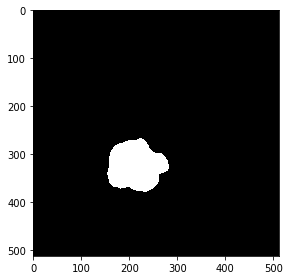

In [33]:
from skimage import data, io
from matplotlib import pyplot as plt
io.imshow(output)
plt.show()